Generate Training sets
=====================

Based on "Reproducible Experiments" notebook


In [1]:
%matplotlib inline

In [7]:
# here the usual imports. If any of the imports fails, 
# make sure that pynoddy is installed
# properly, ideally with 'python setup.py develop' 
# or 'python setup.py install'
import sys, os
import matplotlib.pyplot as plt
import numpy as np
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
sys.path.append(repo_path)
import pynoddy
import pynoddy.history
import pynoddy.experiment
import importlib
importlib.reload(pynoddy.experiment)
rcParams.update({'font.size': 15})

In [8]:
# From notebook 4/ Traning Set example 1:
importlib.reload(pynoddy.history)
importlib.reload(pynoddy.events)
nm = pynoddy.history.NoddyHistory()
# add stratigraphy
strati_options = {'num_layers' : 3,
                  'layer_names' : ['layer 1', 'layer 2', 'layer 3'],
                  'layer_thickness' : [1500, 500, 1500]}
nm.add_event('stratigraphy', strati_options )

# The following options define the fault geometry:
fault_options = {'name' : 'Fault_E',
                 'pos' : (4000, 0, 5000),
                 'dip_dir' : 90.,
                 'dip' : 60,
                 'slip' : 1000}

nm.add_event('fault', fault_options)
history = 'normal_fault.his'
output_name = 'normal_fault_out'
nm.write_history(history)

Initiate experiment with this input file:

In [9]:
importlib.reload(pynoddy.history)
importlib.reload(pynoddy.experiment)

from pynoddy.experiment import monte_carlo
ue = pynoddy.experiment.Experiment(history)

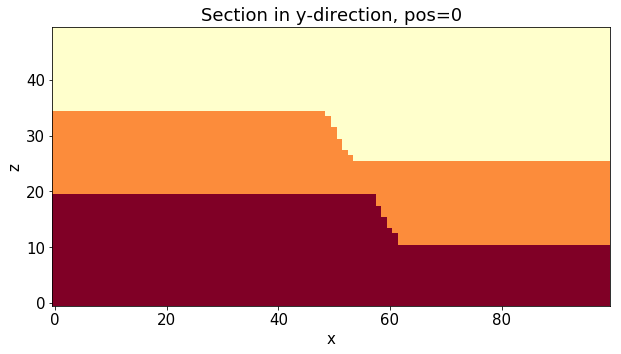

In [10]:
ue.change_cube_size(100)
ue.plot_section('y')

Before we start to draw random realisations of the model, we should first store the base state of the model for later reference. This is simply possibel with the freeze() method which stores the current state of the model as the "base-state":

In [11]:
ue.freeze()

We now intialise the random generator. We can directly assign a random seed to simplify reproducibility (note that this is not *essential*, as it would be for the definition in a script function: the random state is preserved within the model and could be retrieved at a later stage, as well!):

In [12]:
ue.set_random_seed(12345)

The next step is to define probability distributions to the relevant event parameters. Let's first look at the different events:

In [13]:
ue.info(events_only = True)

This model consists of 2 events:
	(1) - STRATIGRAPHY
	(2) - FAULT



In [14]:
ev2 = ue.events[2]

In [15]:
ev2.properties

{'Geometry': 'Translation',
 'Movement': 'Hanging Wall',
 'X': 4000.0,
 'Y': 0.0,
 'Z': 5000.0,
 'Dip Direction': 90.0,
 'Dip': 60.0,
 'Pitch': 90.0,
 'Slip': 1000.0,
 'Rotation': 30.0,
 'Amplitude': 2000.0,
 'Radius': 1000.0,
 'XAxis': 2000.0,
 'YAxis': 2000.0,
 'ZAxis': 2000.0,
 'Cyl Index': 0.0,
 'Profile Pitch': 90.0,
 'Color Name': 'Custom Colour 8',
 'Red': 0.0,
 'Green': 0.0,
 'Blue': 254.0}

Next, we define the probability distributions for the uncertain input parameters:

In [16]:
param_stats = [{'event' : 2, 
              'parameter': 'Slip',
              'stdev': 300.0,
              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'Dip',
              'stdev': 10.0,
              'type': 'normal'},]

ue.set_parameter_statistics(param_stats)

In [17]:
resolution = 100
ue.change_cube_size(resolution)
tmp = ue.get_section('y')
prob_2 = np.zeros_like(tmp.block[:,:,:])
n_draws = 10


for i in range(n_draws):
    ue.random_draw()
    tmp = ue.get_section('y', resolution = resolution)
    prob_2 += (tmp.block[:,:,:] == 2)

# Normalise
prob_2 = prob_2 / float(n_draws)

Text(0, 0.5, 'z')

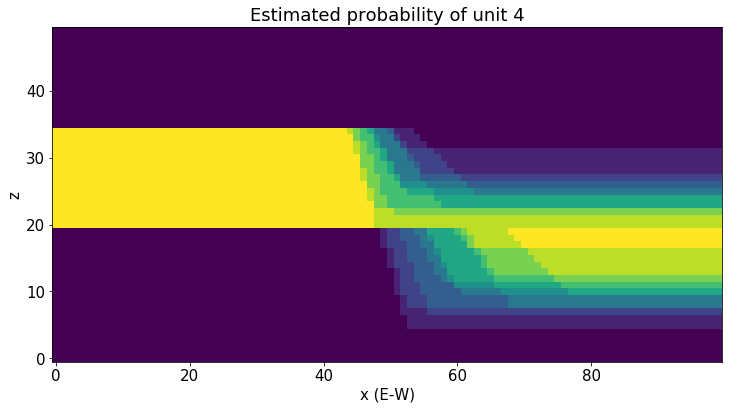

In [18]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
ax.imshow(prob_2.transpose()[:,0,:], 
           origin = 'lower left',
           interpolation = 'none')
plt.title("Estimated probability of unit 4")
plt.xlabel("x (E-W)")
plt.ylabel("z")

This example shows how the base module for reproducible experiments with kinematics can be used. For further specification, child classes of `Experiment` can be defined, and we show examples of this type of extension in the next sections.

## Adjustments to generate training set

First step: generate more layers and randomly select layers to visualise:

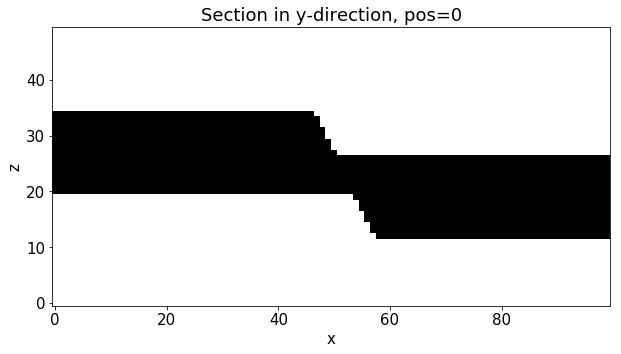

In [19]:
ue.random_draw()
s1 = ue.get_section('y')
s1.block.shape
s1.block[np.where(s1.block == 3)] = 1
s1.plot_section('y', cmap='Greys')

**Idea**: generate many layers, then randomly extract a couple of these and also assign different density/ color values:

In [20]:
nm = pynoddy.history.NoddyHistory()
# add stratigraphy

n_layers = 8

strati_options['num_layers'] = n_layers
strati_options['layer_names'] = []
strati_options['layer_thickness'] = []

for n in range(n_layers):

    strati_options['layer_names'].append("layer %d" % n)
    strati_options['layer_thickness'].append(5000./n_layers)

nm.add_event('stratigraphy', strati_options )

# The following options define the fault geometry:
fault_options = {'name' : 'Fault_E',
                 'pos' : (1000, 0, 5000),
                 'dip_dir' : 90.,
                 'dip' : 60,
                 'slip' : 500}

nm.add_event('fault', fault_options)
history = 'normal_fault.his'
output_name = 'normal_fault_out'
nm.write_history(history)

In [21]:
importlib.reload(pynoddy.history)
importlib.reload(pynoddy.experiment)

from pynoddy.experiment import monte_carlo
ue = pynoddy.experiment.Experiment(history)
ue.freeze()
ue.set_random_seed(12345)
ue.set_extent(2800, 100, 2800)

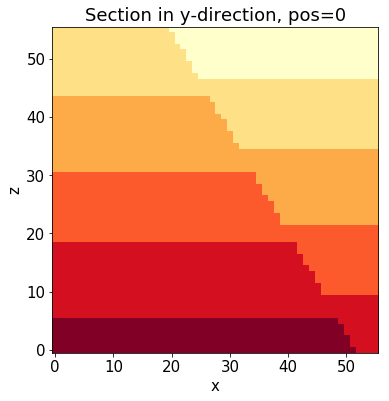

In [22]:
ue.change_cube_size(50)
ue.plot_section('y')

In [23]:
param_stats = [{'event' : 2, 
              'parameter': 'Slip',
              'stdev': 100.0,
              'type': 'lognormal'},
              {'event' : 2, 
              'parameter': 'Dip',
              'stdev': 10.0,
              'type': 'normal'},
#              {'event' : 2, 
#              'parameter': 'Y',
#              'stdev': 150.0,
#              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'X',
              'stdev': 150.0,
              'type': 'normal'},]

ue.set_parameter_statistics(param_stats)

In [24]:
# randomly select layers:
ue.random_draw()

In [25]:
s1 = ue.get_section('y')

In [26]:
# create "feature" model:
f1 = s1.block.copy()

In [27]:
# randomly select layers:
f1 = np.squeeze(f1)
# n_featuers: number of "features" -> gray values in image
n_features = 5
vals = np.random.randint(0,255,size=n_features)
for n in range(n_layers):
    f1[f1 == n] = np.random.choice(vals)

In [28]:
f1.shape

(56, 56)

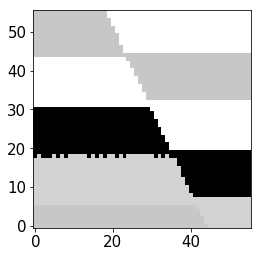

In [29]:
plt.imshow(f1.T, origin='lower_left', cmap='Greys', interpolation='nearest')

In [30]:
# blur image
from scipy import ndimage
f2 = ndimage.filters.gaussian_filter(f1, 1, mode='nearest')


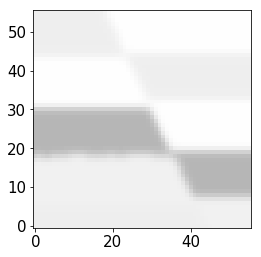

In [31]:
plt.imshow(f2.T, origin='lower_left', cmap='Greys', interpolation='nearest', vmin=0, vmax=255)

In [32]:
# randomly swap image
if np.random.randint(2) == 1:
    f2 = f2[::-1,:]

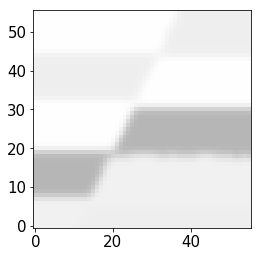

In [33]:
plt.imshow(f2.T, origin='lower_left', cmap='Greys', interpolation='nearest', vmin=0, vmax=255)

## All in one function

### Generate images for normal faults

In [35]:
# back to before: re-initialise model:
nm = pynoddy.history.NoddyHistory()
# add stratigraphy

n_layers = 18

strati_options['num_layers'] = n_layers
strati_options['layer_names'] = []
strati_options['layer_thickness'] = []

for n in range(n_layers):

    strati_options['layer_names'].append("layer %d" % n)
    strati_options['layer_thickness'].append(5000./n_layers)

nm.add_event('stratigraphy', strati_options )

# The following options define the fault geometry:
fault_options = {'name' : 'Fault_E',
                 'pos' : (1000, 0, 5000),
                 'dip_dir' : 90.,
                 'dip' : 60,
                 'slip' : 500}

nm.add_event('fault', fault_options)
history = 'normal_fault.his'
output_name = 'normal_fault_out'
nm.write_history(history)

from pynoddy.experiment import monte_carlo
ue = pynoddy.experiment.Experiment(history)
ue.freeze()
ue.set_random_seed(12345)
ue.set_extent(2800, 100, 2800)
ue.change_cube_size(50)

param_stats = [{'event' : 2, 
              'parameter': 'Slip',
              'stdev': 100.0,
              'type': 'lognormal'},
              {'event' : 2, 
              'parameter': 'Dip',
              'stdev': 10.0,
              'type': 'normal'},
#              {'event' : 2, 
#              'parameter': 'Y',
#              'stdev': 150.0,
#              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'X',
              'stdev': 150.0,
              'type': 'normal'},]

ue.set_parameter_statistics(param_stats)

Generate training set for normal faults:

In [36]:
n_train = 10000
F_train = np.empty((n_train, 28*28))

ue.change_cube_size(100)

for i in range(n_train):
    # randomly select layers:
    ue.random_draw()
    s1 = ue.get_section('y')
    # create "feature" model:
    f1 = s1.block.copy()
    # randomly select layers:
    f1 = np.squeeze(f1)
    # n_featuers: number of "features" -> gray values in image
    n_features = 4
    vals = np.random.randint(0,255,size=n_features)
    for n in range(n_layers):
        f1[f1 == n+1] = np.random.choice(vals)
    f1 = f1.T
    f2 = ndimage.filters.gaussian_filter(f1, 0, mode='nearest')
    # scale image
    f2 = f2 - np.min(f2)
    if np.max(f2) != 0:
        f2 = f2/np.max(f2)*255
    # randomly swap image
    if np.random.randint(2) == 1:
        f2 = f2[::-1,:]
    F_train[i] = f2.flatten().T


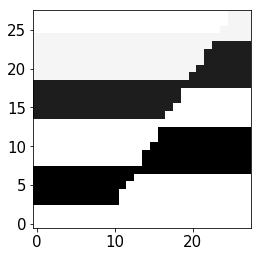

In [37]:
plt.imshow(f2, origin='lower_left', cmap='Greys', interpolation='nearest', vmin=0, vmax=255)

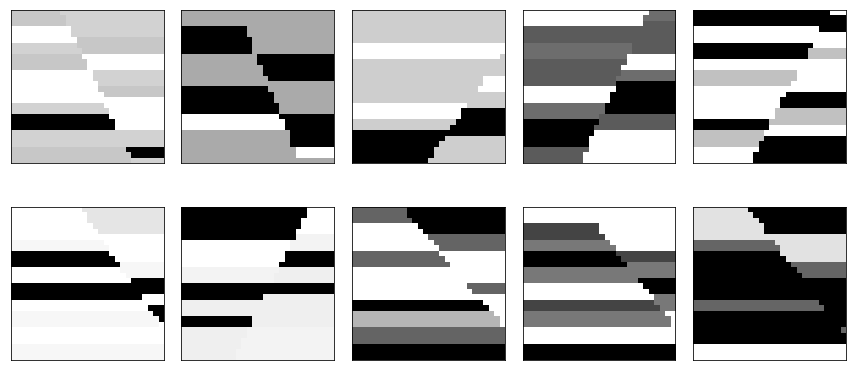

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12,6))
ax = ax.flatten()
for i in range(10):
    img = F_train[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

In [39]:
import pickle


In [45]:
f = open("f_train_normal.pkl", 'wb')
pickle.dump(F_train, f)

### Generate reverse faults

And now: the same for reverse faults:

In [597]:
# back to before: re-initialise model:
nm = pynoddy.history.NoddyHistory()
# add stratigraphy

n_layers = 18

strati_options['num_layers'] = n_layers
strati_options['layer_names'] = []
strati_options['layer_thickness'] = []

for n in range(n_layers):

    strati_options['layer_names'].append("layer %d" % n)
    strati_options['layer_thickness'].append(5000./n_layers)

nm.add_event('stratigraphy', strati_options )

# The following options define the fault geometry:
fault_options = {'name' : 'Fault_E',
                 'pos' : (1000, 0, 5000),
                 'dip_dir' : 90.,
                 'dip' : 60,
                 'slip' : -500}

nm.add_event('fault', fault_options)
history = 'normal_fault.his'
output_name = 'normal_fault_out'
nm.write_history(history)

reload(pynoddy.history)
reload(pynoddy.experiment)

from pynoddy.experiment import monte_carlo
ue = pynoddy.experiment.Experiment(history)
ue.freeze()
ue.set_random_seed(12345)
ue.set_extent(2800, 100, 2800)
ue.change_cube_size(50)

param_stats = [{'event' : 2, 
              'parameter': 'Slip',
              'stdev': -100.0,
              'type': 'lognormal'},
              {'event' : 2, 
              'parameter': 'Dip',
              'stdev': 10.0,
              'type': 'normal'},
#              {'event' : 2, 
#              'parameter': 'Y',
#              'stdev': 150.0,
#              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'X',
              'stdev': 150.0,
              'type': 'normal'},]

ue.set_parameter_statistics(param_stats)

In [6]:
n_train = 10000
F_train_rev = np.empty((n_train, 28*28))

ue.change_cube_size(100)

for i in range(n_train):
    # randomly select layers:
    ue.random_draw()
    s1 = ue.get_section('y')
    # create "feature" model:
    f1 = s1.block.copy()
    # randomly select layers:
    f1 = np.squeeze(f1)
    # n_featuers: number of "features" -> gray values in image
    n_features = 
    vals = np.random.randint(0,255,size=n_features)
    for n in range(n_layers):
        f1[f1 == n+1] = np.random.choice(vals)
    f1 = f1.T
    f2 = ndimage.filters.gaussian_filter(f1, 0, mode='nearest')
    # scale image
    f2 = f2 - np.min(f2)
    if np.max(f2) != 0:
        f2 = f2/np.max(f2)*255
    # randomly swap image
    if np.random.randint(2) == 1:
        f2 = f2[::-1,:]
    F_train_rev[i] = f2.flatten().T



AttributeError: 'Experiment' object has no attribute 'base_events'

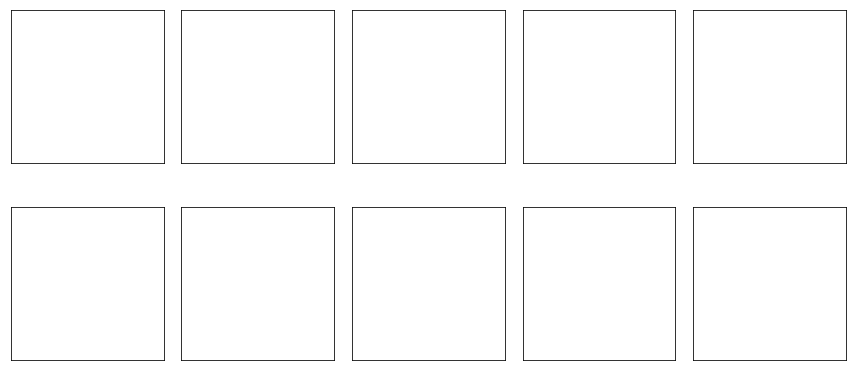

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12,6))
ax = ax.flatten()
for i in range(10):
    img = F_train_rev[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

In [600]:
pickle.dump(F_train_rev, open("f_train_reverse.pkl", 'w'))

### Generate simple layer structure

No need for noddy, in this simple case - just adapt a numpy array:

In [604]:
l1 = np.empty_like(s1.block[:,0,:])

In [650]:
n_layers = 18
for i in range(l1.shape[0]):
    l1[:,i] = i
l1_ori = np.floor(l1*n_layers/l1.shape[0])

In [655]:
F_train_line = np.empty((n_train, 28*28))



for i in range(n_train):
    n_features = 4
    vals = np.random.randint(0,255,size=n_features)
    l1 = l1_ori.copy()
    for n in range(n_layers):
        l1[l1 == n+1] = np.random.choice(vals)
    f1 = l1.T
    f2 = ndimage.filters.gaussian_filter(f1, 0, mode='nearest')
    # scale image
    f2 = f2 - np.min(f2)
    if np.max(f2) != 0:
        f2 = f2/np.max(f2)*255
    F_train_line[i] = f2.flatten().T

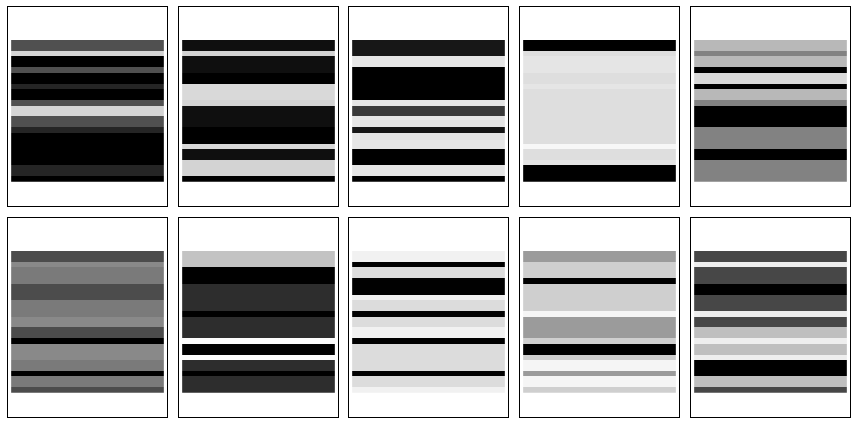

In [656]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12,6))
ax = ax.flatten()
for i in range(10):
    img = F_train_line[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

In [657]:
pickle.dump(F_train_line, open("f_train_line.pkl", 'w'))